# Quasilinear Diffusion operator

First attempt to calculate the QL diffusion based on a file from WKBeam.

Initially, only stored in rho and the components of N.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import QL_functs_v2 as ql


In [2]:
filename = '/home/devlamin/Documents/WKBeam_related/WKBacca_dev_v1/WKBacca_cases/TCV72644/t_1.05/output/L1_binned_QL.hdf5'

In [3]:
WhatToResolve, FreqGHz, mode, Wfct, Absorption, EnergyFlux, rho, Theta, Nparallel, Nperp = ql.read_h5file(filename)


In [4]:
Wfct_maxdens = np.amax(Wfct)
print('Wfct_maxdens:', Wfct_maxdens)

Wfct_maxdens: 0.0015681295724248965


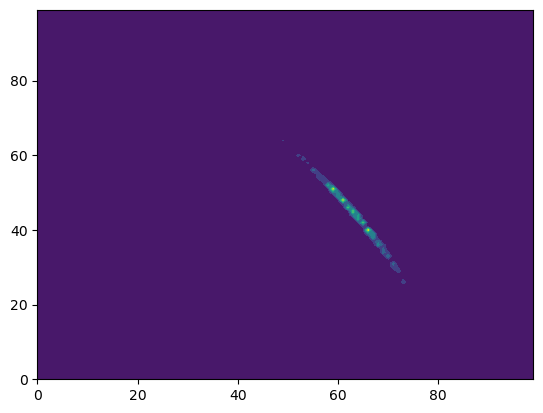

In [10]:
plt.contourf(Wfct[10, 50, :, :, 0])

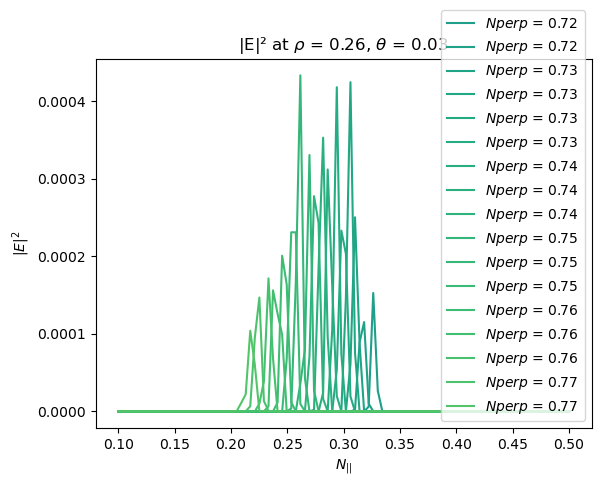

In [11]:
colors = plt.cm.get_cmap('viridis')(np.linspace(0,1,len(Nperp)))

for i in range(len(Nperp)):
    if Wfct[10, 50, :, i, 0].max() > 1e-4:
        plt.plot(Nparallel, Wfct[10, 50, :, i, 0], label=rf'$Nperp$ = {Nperp[i]:.2f}', color=colors[i])
plt.title(rf'|E|² at $\rho$ = {rho[10]:.2f}, $\theta$ = {Theta[50]:.2f}')
plt.xlabel(r'$N_{||}$')
plt.ylabel(r'$|E|^2$')
#plt.xlim(-0.55, -0.1)
plt.legend(loc='lower right')

In [12]:
beam_mask = np.where(Wfct < 1e-4*Wfct_maxdens, False, True)

Wfct = np.where(beam_mask, Wfct, np.nan)

percentage_filled_Wfct = Wfct[beam_mask].size / Wfct.size * 100
print(f'{percentage_filled_Wfct:.2f}% of the phase space is occupied.')

Vel_par = np.where(beam_mask, EnergyFlux[:, :, :, :, 0, :] / Wfct, np.nan)
Vel_perp = np.where(beam_mask, EnergyFlux[:, :, :, :, 1, :] / Wfct, np.nan)


Vel = np.sqrt(Vel_par**2 + Vel_perp**2)


0.40% of the phase space is occupied.


In [13]:
Nparpar, Nperper = np.meshgrid(Nparallel, Nperp, indexing='ij')

N = np.sqrt(Nparpar**2 + Nperper**2)

/tmp/ipykernel_56132/2061229585.py:1: RuntimeWarning: Mean of empty slice
  N_avg = np.array([[np.nanmean(N[beam_mask[i, j, :, :, 0]]) for j in range(len(Theta))] for i in range(len(rho))])


Text(0.5, 1.0, 'Percentage of N-space filled')

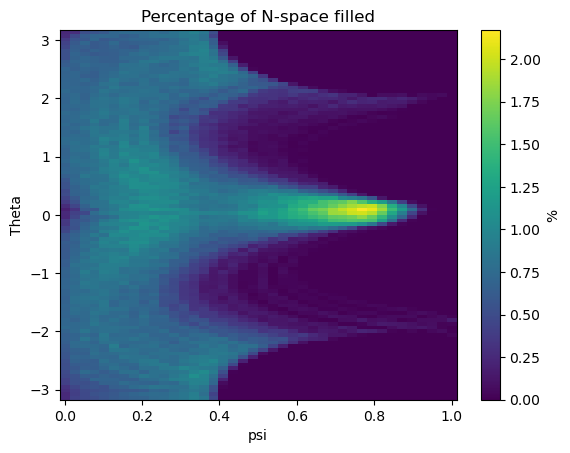

In [14]:
N_avg = np.array([[np.nanmean(N[beam_mask[i, j, :, :, 0]]) for j in range(len(Theta))] for i in range(len(rho))])
N_avg_psi = np.nanmean(N_avg, axis=1)
percentage_filled = np.array([[N[beam_mask[i, j, :, :, 0]].shape[0] / N.size for j in range(len(Theta))] for i in range(len(rho))])

fig = plt.figure()
ax = fig.add_subplot(111)
p1 = ax.pcolormesh(rho, Theta, 100*percentage_filled.T)

plt.colorbar(p1, label='%')
ax.set_xlabel('psi')
ax.set_ylabel('Theta')
ax.set_title('Percentage of N-space filled')



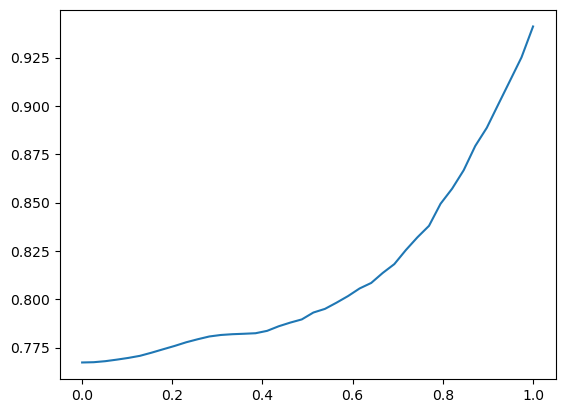

In [15]:
plt.plot(rho, N_avg_psi, label='N_avg')

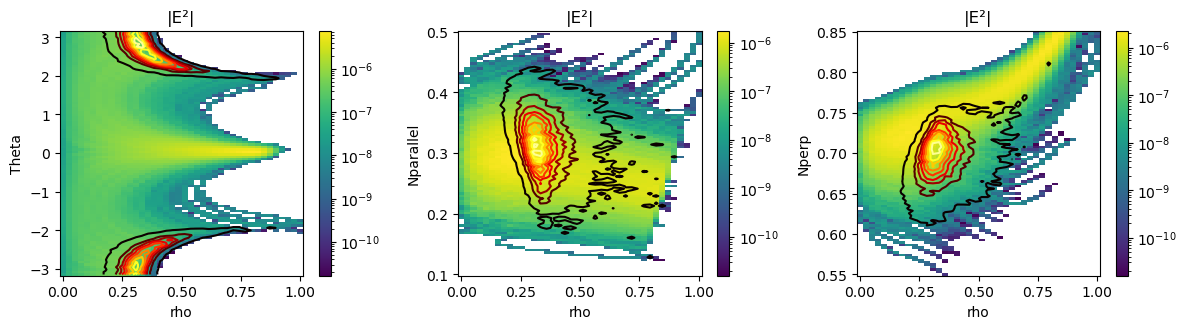

In [16]:
Wfct_rho_Theta = ql.sum_over_dimensions(Wfct, [-3, -2])

Wfct_rho_Nparallel = ql.sum_over_dimensions(Wfct, [-4, -2])
Wfct_rho_Nperp = ql.sum_over_dimensions(Wfct, [-4, -3])


plt.figure(figsize=(12, 6))
ax1 = plt.subplot(2, 3, 1)
plot1 = ax1.pcolormesh(rho, Theta, Wfct_rho_Theta[:, :, 0].T, norm=LogNorm())
plt.colorbar(plot1)
Absorption = np.where(beam_mask, Absorption, np.nan)
Abs_rho_Theta = ql.sum_over_dimensions(Absorption, [-3, -2])
Abs_max= np.nanmax(Abs_rho_Theta[:, :, 0])
ax1.contour(rho, Theta, Abs_rho_Theta[:, :, 0].T, levels=np.linspace(Abs_max/100, Abs_max, 10), cmap='hot')
#ax1.set_facecolor('white')
ax1.set_xlabel('rho')
ax1.set_ylabel('Theta')
ax1.set_title('|E²|')


ax2 = plt.subplot(2, 3, 2)
plot2 = ax2.pcolormesh(rho, Nparallel, Wfct_rho_Nparallel[:, :, 0].T, norm=LogNorm())
plt.colorbar(plot2)
Abs_rho_Nparallel = ql.sum_over_dimensions(Absorption, [-4, -2])
Abs_max= np.nanmax(Abs_rho_Nparallel[:, :, 0])
ax2.contour(rho, Nparallel, Abs_rho_Nparallel[:, :, 0].T, levels=np.linspace(Abs_max/100, Abs_max, 10), cmap='hot')
ax2.set_xlabel('rho')
ax2.set_ylabel('Nparallel')
ax2.set_title('|E²|')

ax3 = plt.subplot(2, 3, 3)
plot3 = ax3.pcolormesh(rho, Nperp, Wfct_rho_Nperp[:, :, 0].T, norm=LogNorm())
plt.colorbar(plot3)
Abs_rho_Nperp = ql.sum_over_dimensions(Absorption, [-4, -3])
Abs_max= np.nanmax(Abs_rho_Nperp[:, :, 0])
ax3.contour(rho, Nperp, Abs_rho_Nperp[:, :, 0].T, levels=np.linspace(Abs_max/100, Abs_max, 10), cmap='hot')
ax3.set_xlabel('rho')
ax3.set_ylabel('Nperp')
ax3.set_title('|E²|')

"""
ax4 = plt.subplot(2, 3, 4)
Vel_par_rho_Theta = ql.sum_over_dimensions(Vel_par, [-3, -2])
Vel_perp_rho_Theta = ql.sum_over_dimensions(Vel_perp, [-3, -2])

plot4 = ax4.pcolormesh(rho, Theta, Vel_par_rho_Theta[:, :, 0].T)
plt.colorbar(plot4)
plt.xlabel('rho')
plt.ylabel('Theta')
plt.title('Vel_par')

ax5 = plt.subplot(2, 3, 5)
plot5 = ax5.pcolormesh(rho, Theta, Vel_perp_rho_Theta[:, :, 0].T)   
plt.colorbar(plot5)
plt.xlabel('rho')
plt.ylabel('Theta')
plt.title('Vel_perp')
"""
plt.tight_layout()


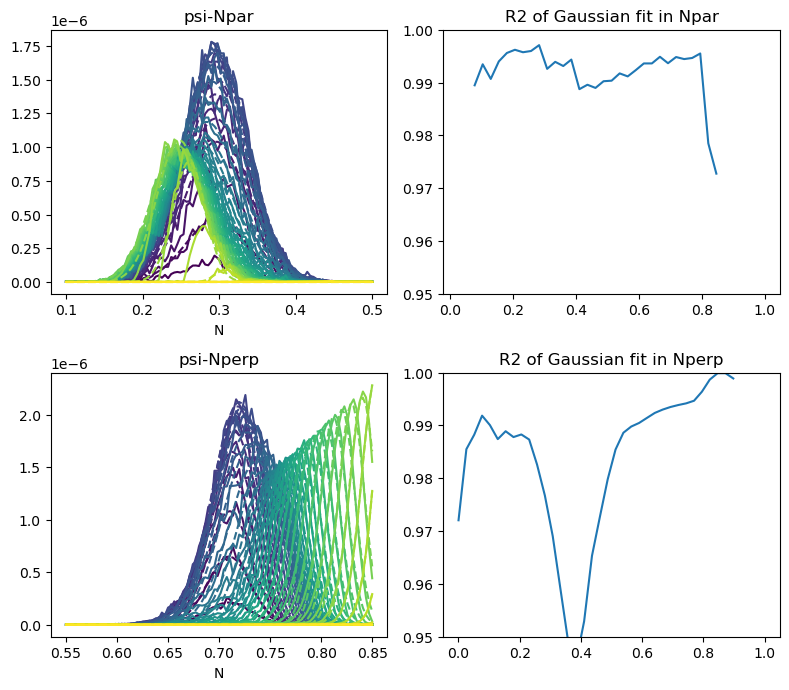

In [17]:
colors = plt.cm.get_cmap('viridis')(np.linspace(0,1,Wfct_rho_Nparallel.shape[0]))

from scipy.optimize import curve_fit

def gaussian(x, a, b, c):
    return a*np.exp(-(x-b)**2/(2*c**2))

def R2(y, y_fit):
    return 1 - np.sum((y - y_fit)**2) / np.sum((y - np.mean(y))**2)

plt.figure(figsize=(8, 10))
firstguess_pos = [-0.35, 0.8]
dimension = ['par', 'perp'] 
for dim in range(2):
    gauss = plt.subplot(3, 2, 2*dim+1)
    if dim == 0:
        N = Nparallel
        Wfct_psi_N = Wfct_rho_Nparallel
    else:
        N = Nperp
        Wfct_psi_N = Wfct_rho_Nperp


    R2s = []
    width_over_avg = []
    for i in range(0, Wfct_psi_N.shape[0], 1):
        gauss.plot(N, Wfct_psi_N[i, :, 0], color=colors[i], label=f'psi={rho[i]:.2f}')
        try:
            popt, pcov = curve_fit(gaussian, N, Wfct_psi_N[i, :, 0], p0=[3e-5, firstguess_pos[dim], 0.1])
        except:
            popt = [np.nan, np.nan, np.nan]
        R2s.append(R2(Wfct_psi_N[i, :, 0], gaussian(N, *popt)))
        width_over_avg.append(popt[2] / popt[1])
        try:
            gauss.plot(N, gaussian(N, *popt), color=colors[i], linestyle='--')
        except:
            pass

        gauss.set_title(f'psi-N{dimension[dim]}')
        gauss.set_xlabel('N')



    r2 = plt.subplot(3, 2, 2*dim+2)
    r2.plot(rho[::1], R2s, label='width/avg')
    r2.set_ylim(.95, 1)
    r2.set_title(f'R2 of Gaussian fit in N{dimension[dim]}')

plt.tight_layout()



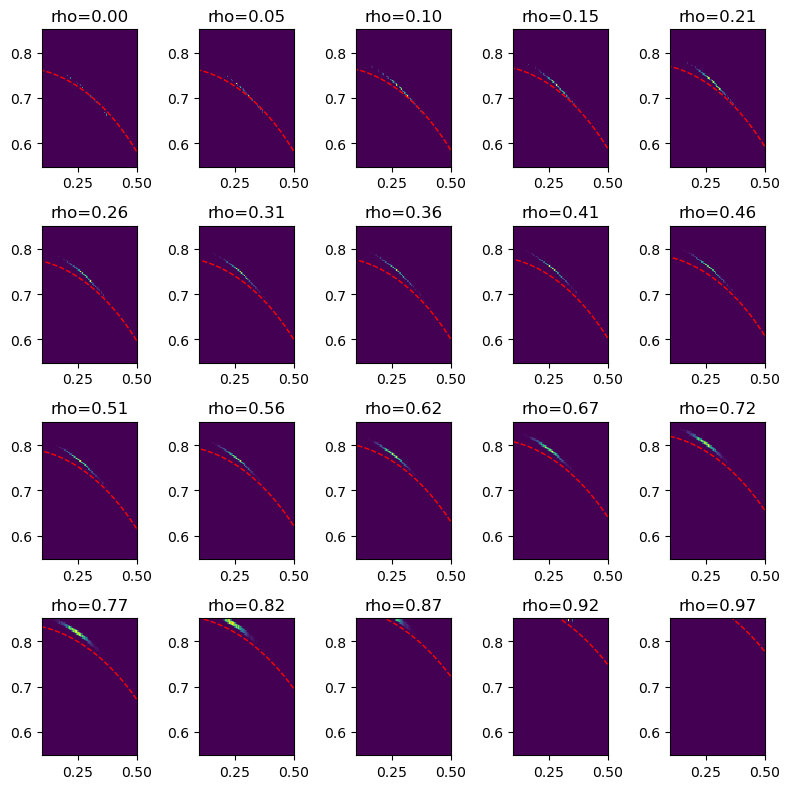

In [31]:
#Wfct_psi_Npar_Nperp = ql.sum_over_dimensions(Wfct, [-4])
Wfct_psi_Npar_Nperp = Wfct[:, 50, :, :, :]
Wfct_nonNan = np.where(np.isnan(Wfct_psi_Npar_Nperp), 0, Wfct_psi_Npar_Nperp)
NPAR, NPERP = np.meshgrid(Nparallel, Nperp, indexing='ij')
N_norm = np.sqrt(NPAR**2 + NPERP**2)
plt.figure(figsize=(8, 8))
for i in range(0, Wfct_nonNan.shape[0], 2):

    
    plt.subplot(4, 5, i//2+1)
    plt.pcolormesh(Nparallel, Nperp, Wfct_nonNan[i, :, :, 0].T)
    plt.contour(NPAR, NPERP, N_norm, [N_avg_psi[i]], colors='r', linestyles='dashed', linewidths=1)
    plt.title(f'rho={rho[i]:.2f}')

plt.tight_layout()
    
    

In [ ]:
import sparray

In [ ]:
# Calculate the product of both for every point in the grid, by summing over the k-space

p_norm = np.linspace(0.01, 20, 500)
ksi = np.linspace(-1, 1, 500)

P_norm, Ksi = np.meshgrid(p_norm, ksi)

P_par, P_perp = P_norm * Ksi, P_norm * np.sqrt(1 - Ksi**2)

###
# Caltulate a 'volume element' in the k-space

dNpar = Npar[1] - Npar[0]
dNperp = Nperp[1] - Nperp[0]
dV = dNpar * dNperp


###
# For now, just take the central angle, ignore the rest
Wfct_psi_Npar_Nperp = Wfct[:, 49, :, :, 0]
E_sq = np.where(np.isnan(Wfct_psi_Npar_Nperp), 0, Wfct_psi_Npar_Nperp)
mask = np.where(np.isnan(Wfct_psi_Npar_Nperp), False, True)

        

In [ ]:
print(E_sq.shape, E_sq.size)
print(Wfct_psi_Npar_Nperp[mask].shape, Wfct_psi_Npar_Nperp[mask].size)
print(f'Size reduction: {Wfct_psi_Npar_Nperp[mask].size / Wfct_psi_Npar_Nperp.size * 100:.2f}% of original')


In [ ]:
mask_full = np.where(np.isnan(Wfct), False, True)
E_sq_full = np.where(np.isnan(Wfct), 0, Wfct)

print(E_sq_full.shape, E_sq_full.size)
print(Wfct[mask_full].shape, Wfct[mask_full].size)
print(f'Size reduction: {Wfct[mask_full].size / Wfct.size * 100:.2f}% of original')

In [ ]:
mask_psitheta = np.where(Wfct_psi_Theta < 1e-8, False, True)
E_sq_psitheta = np.where(mask_psitheta, Wfct_psi_Theta, 0)

print(E_sq_psitheta.shape, E_sq_psitheta.size)
print(Wfct_psi_Theta[mask_psitheta].shape, Wfct_psi_Theta[mask_psitheta].size)
print(f'Size reduction: {Wfct_psi_Theta[mask_psitheta].size / Wfct_psi_Theta.size * 100:.2f}% of original')

In [ ]:
20*100*40*40


In [ ]:
# boltzmann constant
kB = 1.38064852e-23 # 
# electron mass
m_e = 9.10938356e-31
#speed of light
c = 299792458

cm_e = c * m_e

# electron charge
e = 1.60217662e-19 # C

# conversion eV to K
eV2K = 11604.52500617

eV2K* kB/(m_e*c**2)

In [ ]:
np.sqrt(1 + ql.beta_from_Te(1e3))

In [ ]:
Nparpar, Nperper = np.meshgrid(Npar, Nperp, indexing='ij')

N2 = Nparpar**2 + Nperper**2
k_angle = np.arctan2(Nperper, Nparpar)

In [ ]:
from scipy.spatial import KDTree


# And how do we get sparsity???

def QL_diff(E_sq, rho, P_norm, Ksi, Npar, Nperp, n=[2], freq=82.7):
    # Calculate the product in the integrand and sum over the k-space
    # we do this straight away in the full phase space. 
    # So rho is a 1D array, P_norm and Ksi are 2D arrays, Npar and Nperp are 1D arrays

    # Attemped implementation of the QL operator
    #For now, just a code skeleton

    
    # the momentum is normalised to c*m_e. The thermal momentum is flux-surface dependent however, so we need another 'base value'.
    # Gamma can already be calculated in terms of the unnormalised momentum, to save calculations.

    P_unnormalised = cm_e * P_norm  # Unnormalised momentum.
    gamma = ql.gamma(P_unnormalised)  # Lorentz factor, also on grid of P_norm and Ksi

    # Something else we can already do, is make the KDtree for Npar. This will help us to quickly perform the Kronecker delta function.

    Npar_tree = KDTree(Npar.reshape(-1, 1))
    dNpar = Npar[1] - Npar[0]

    Nparpar, Nperper = np.meshgrid(Npar, Nperp, indexing='ij')
    N2 = Nparpar**2 + Nperper**2
    k_angle = np.arctan2(Nperper, Nparpar)
    

    QL_nobounce = np.zeros([len(rho),len(Theta), len(P_norm), len(Ksi)])

    for harm in n:
        # We have to perform the full calculation for each harmonic.

        for i_rho, rho_val in enumerate(rho):

            P               = ql.P(rho_val, freq)  # 1 - w_pe^2 / w_b^2 # Polarisation auxilliary function

            for i_theta, theta_val in enumerate(Theta):
                # For reasons discussed in the notes, the iterations over rho and theta are done explicitly.
            
                
                # Calculate/retrieve the volume element in real space

                V = ql.V(rho_val, theta_val)  # Volume element in real space

                # Calculate the polarisation auxilliary functions just once per physical point

                X = ql.X(rho_val, theta_val, freq)  # w_ce / w_b
                R = (P + X)/(1+X)
                L = (P - X)/(1-X)
                S = .5 * (R + L) 
                
                
                # resonance_N_par gives a 2D array with the same shape as P_norm and Ksi
                # This whole calculation is done dimensionless now.

                #P_norm is normalised to P_base, so P_norm/p_Te_factor is P/P_Te

                resonance_N_par = ql.N_par_resonant(P_norm, Ksi, gamma, X, harm) 

                # We can now query the KDTree to get the indices of the resonant values in Npar.
                # The code below efficiently looks for the index of the value in Npar that is closest to the resonant value.
                # This is done for every point in the grid. If it is not within dNpar/2 of any value in Npar, the index is set to -1.
                # This in fact replaces the integral over Npar, as we now just have a 2D array indicating what value of Npar is resonant, if any.

                dist_N_par, ind_N_par = Npar_tree.query(np.expand_dims(resonance_N_par, axis=-1), distance_upper_bound=dNpar/2)
                res_condition_N_par = np.where(np.isinf(dist_N_par), -1, ind_N_par)

                res_mask_Pspace = np.where(res_condition_N_par != -1, True, False) # Mask for the resonant values in P_norm and Ksi
                i_P_res, i_Ksi_res = np.where(res_mask_Pspace) # Tuple containing 2 arrays. 
                # The first array contains the indices of the resonant values in P_norm, the second in Ksi.

                # We can now use the mask to select the resonant values in P_norm and Ksi, and calculate the integrand. 
                # Where there is no Npar value resonant, we can skip the calculation.


                for i_P, i_Ksi in zip(i_P_res, i_Ksi_res):
                                        
                    i_npar = res_condition_N_par[i_P, i_Ksi]
                    # At this point, we check |E|² to see if at rho_val, theta_val, Npar[i_npar] (for this P,Ksi), the beam is present.
                    # And if so, for what value of Nperp.

                    mask_beam_present = np.where(E_sq[i_rho, i_theta, i_npar, :, 0] > 0, True, False)
                    # Make a list of the indices of the Nperp values where the beam is present
                    indeces_Nperp_beam_present = np.where(mask_beam_present)


                    # Calculate the polarisation for the cells where the beam is present
                    # Now that we've pruned all the data so heavily, finally we can calculate the polarisation for the beam cells.

                    for i_nperp in indeces_Nperp_beam_present:
                        pol = ql.polarisation(N2[i_npar, i_nperp], k_angle[i_npar, i_nperp], P, R, L, S)
                        A_perp = ql.A_perp(Nperp[i_nperp], P_norm[i_P, i_Ksi], Ksi[i_P, i_Ksi], X)
                        #Take the bessel functions...
                        #
                        #And combine to get polarisation term
                        #
                        Pol_term = 1

                        # And finally, the integrand is calculated.
                        QL_nobounce[i_rho, i_theta, i_P, i_Ksi] += Nperp[i_nperp] * Pol_term * E_sq[i_rho, i_theta, i_npar, i_nperp, 0]

    return QL_nobounce
                        

In [ ]:
import random

a = np.random.rand(4, 4)

mask = np.where(a > 0.5, True, False)
i_x, i_y= np.where(mask)
print(i_x, i_y)
print(a[i_x, i_y])


In [ ]:
a = np.reshape(P_norm, (-1,1))

a.shape

In [ ]:
                    pl = plt.contour(P_par, P_perp, resonance_N_par, levels=np.linspace(-1, 1, 11), cmap='coolwarm')
                    norescon = plt.contour(P_par, P_perp, res_condition_N_par, colors='k', levels=[-1])
                    rescon = plt.contourf(P_par, P_perp, res_condition_N_par, cmap='Greens', levels=np.arange(0, len(Npar)))
                    plt.clabel(pl, inline=True, fontsize=8)
                    plt.colorbar(rescon, label='Npar index')
                    plt.xlabel('P_par')
                    plt.ylabel('P_perp')
                    plt.title(f'Npar required for resonance at rho = {rho_val:.2f}')
                    plt.show()

In [ ]:
# And how do we get sparsity???
from scipy.spatial import KDTree

def QL_diff(E_sq, rho, P_norm, Ksi, Npar, Nperp, dV, dNpar, n=[2], freq=82.7):
    # Calculate the product in the integrand and sum over the k-space
    # we do this straight away in the full phase space. 
    # So rho is a 1D array, P_norm and Ksi are 2D arrays, Npar and Nperp are 1D arrays
    
    QL = np.zeros([len(rho), len(P_norm), len(Ksi)])

    for i_rho, rho_val in enumerate(rho):
        
        #Here we have to update the fucntions for magnetic field, temperature and beta. Should be called from the equilibrium and have theta dependence
        B_field = ql.B_rho(rho_val)
        Te = ql.Te_rho(rho_val)
        p_Te = ql.beta_from_Te(Te) * m_e * c

        # Then we have to sum over theta with the bounce a averaging
        for harm in n:
            # resonance par gives a 2D array with the same shape as P_norm and Ksi
            resonance_N_par = ql.N_par_resonant(P_norm, Ksi, p_Te, B_field, harm, freq) 

            # We can now query the KDTree to get the indices of the resonant values in Npar.
            """
            Npar_tree = KDTree(np.reshape(Npar, (-1, 1)))
            dist_N_par, ind_N_par = Npar_tree.query(np.expand_dims(resonance_N_par, axis=-1))
            res_condition = np.full(P_norm.shape, -1)
            res_mask = np.where(dist_N_par < dNpar/2, True, False)
            res_condition[res_mask] = ind_N_par[res_mask]
            """
            Npar_tree = KDTree(np.reshape(Npar, (-1, 1)))
            dist_N_par, ind_N_par = Npar_tree.query(np.expand_dims(resonance_N_par, axis=-1), distance_upper_bound=dNpar/2)
            ind_N_par = np.where(np.isinf(dist_N_par), -1, ind_N_par)
            res_condition = ind_N_par


            if i_rho == 4:
                pl = plt.contour(P_par, P_perp, resonance_N_par, levels=np.linspace(-1, 1, 11), cmap='coolwarm')
                norescon = plt.contour(P_par, P_perp, res_condition, colors='k', levels=[-1])
                rescon = plt.contourf(P_par, P_perp, res_condition, cmap='Greens', levels=np.arange(0, len(Npar)))
                plt.clabel(pl, inline=True, fontsize=8)
                plt.colorbar(rescon, label='Npar index')
                plt.xlabel('P_par')
                plt.ylabel('P_perp')
                plt.title(f'Npar required for resonance at rho = {rho_val:.2f}')
                plt.show()
            # res_condition is an Npar x Pnorm x Ksi array checking the resonance condition
            

            # E_sq[i_rho, :, :] is an Npar x Nperp array, dV is a single value
            
            # We multiply it with res_condition to get the integrand,
            # still resolved in P_norm and Ksi.
            #QL[i_rho] += np.einsum('i, ijk->jk',np.sum(E_sq[i_rho, :, :], axis=-1), res_condition) 
                

    return #QL * dV

In [ ]:
q = QL_diff(E_sq, rho, P_norm, Ksi, Npar, Nperp, dV, dNpar, n=[2, 3], freq=82.7)

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(q.shape[0]):
    ax = plt.subplot(4, 5, i+1)
    ax.contourf(P_par, P_perp, q[i, :, :].T, vmax= np.amax(q)/5)
    ax.set_title(f'rho={rho[i]:.2f}')
    ax.set_aspect('equal')

plt.tight_layout()